In [1]:
# Install PYTHON Dependenciesfc
!pip install pandas
!pip install numpy
#!pip install split-folder
!pip install tensorflow
!pip install tensorflow-addons
!pip install vit-keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 1.2 MB/s eta 0:00:00a 0:00:01m
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
google-cloud-translate 3.12.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.29.5 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
pydrive2 1.21.3 requires cryptography<44, but you have cryptography 46.0.3 which is incompatible.
pydrive

In [3]:
#PYTHON IMPORTS
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os # os
# So we can use SplitFolder package
import shutil
from pathlib import Path
import random


##
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG19, MobileNetV3Large, InceptionV3, EfficientNetB3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from vit_keras import vit

from tensorflow.keras import layers, models, applications, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

from itertools import cycle


from sklearn.utils import class_weight

# ENABLE Mixed Precision (Speed Boost for GPU)
from tensorflow.keras import mixed_precision
try:
    mixed_precision.set_global_policy('mixed_float16')
    print("✅ Mixed Precision Enabled")
except:
    print("⚠️ Mixed Precision not available (using float32)")


SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

✅ Mixed Precision Enabled


In [4]:
def split_folders(input_dir, output_dir, ratio=(0.8, 0.1, 0.1), seed=42):
    random.seed(seed)
    # Cleanup existing split to avoid duplication/errors
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
        
    for split in ['train', 'val', 'test']:
        os.makedirs(os.path.join(output_dir, split), exist_ok=True)
    
    input_path = Path(input_dir)
    class_dirs = [d for d in input_path.iterdir() if d.is_dir()]
    
    print(f"Found {len(class_dirs)} classes")
    
    for class_dir in class_dirs:
        class_name = class_dir.name
        files = [f for f in class_dir.iterdir() if f.is_file()]
        random.shuffle(files)
        
        n_files = len(files)
        n_train = int(n_files * ratio[0])
        n_val = int(n_files * ratio[1])
        
        splits = {
            'train': files[:n_train],
            'val': files[n_train:n_train + n_val],
            'test': files[n_train + n_val:]
        }
        
        for split_name, file_list in splits.items():
            split_class_dir = os.path.join(output_dir, split_name, class_name)
            os.makedirs(split_class_dir, exist_ok=True)
            for file in file_list:
                shutil.copy2(str(file), os.path.join(split_class_dir, file.name))
        
        print(f"  {class_name}: {len(splits['train'])} train, {len(splits['val'])} val, {len(splits['test'])} test")

# --- EXECUTE SPLIT ---
data_dir = "/kaggle/input/eye-disease-dataset/dataset" 
split_output_dir = "/kaggle/working/dise_split"

# Run the split
split_folders(data_dir, split_output_dir, ratio=(0.75, 0.125, 0.125), seed=SEED)

Found 4 classes
  glaucoma: 755 train, 125 val, 127 test
  normal: 805 train, 134 val, 135 test
  diabetic_retinopathy: 823 train, 137 val, 138 test
  cataract: 778 train, 129 val, 131 test


In [8]:
# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 64 
AUTOTUNE = tf.data.AUTOTUNE

print("🚀 Building Fast tf.data Pipeline...")

# 1. Load Datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(split_output_dir, 'train'),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=True,
    seed=SEED
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(split_output_dir, 'val'),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(split_output_dir, 'test'),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False
)

# 2. Get Class Names
class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Classes: {class_names}")

# 3. Optimize for Performance (Caching & Prefetching)
def configure_ds(ds, is_train=False):
    if is_train:
        ds = ds.cache() # Cache in RAM (Make sure you have enough RAM, else remove this line)
        ds = ds.shuffle(1000)
    
    ds = ds.prefetch(buffer_size=AUTOTUNE) # Prepare next batch while GPU trains
    return ds

train_ds = configure_ds(train_ds, is_train=True)
val_ds = configure_ds(val_ds)
test_ds = configure_ds(test_ds)

print("✅ Pipeline Optimized")

🚀 Building Fast tf.data Pipeline...
Found 3161 files belonging to 4 classes.
Found 525 files belonging to 4 classes.
Found 531 files belonging to 4 classes.
Classes: ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']
✅ Pipeline Optimized


In [9]:
# Calculate Class Weights based on file counts
train_dir = os.path.join(split_output_dir, 'train')
count_dict = {}
total_files = 0

for cls in sorted(os.listdir(train_dir)):
    count = len(os.listdir(os.path.join(train_dir, cls))) # number of the files exists
    count_dict[cls] = count # 4
    total_files += count

# Calculate weights: Total / (Num_Classes * Class_Count)
c_weights = {} 
print("⚖️ Class Weights:")
for idx, cls in enumerate(class_names):
    weight = total_files / (num_classes * count_dict[cls])
    c_weights[idx] = weight
    print(f"  {cls} (Index {idx}): {weight:.4f}")

⚖️ Class Weights:
  cataract (Index 0): 1.0157
  diabetic_retinopathy (Index 1): 0.9602
  glaucoma (Index 2): 1.0467
  normal (Index 3): 0.9817


In [10]:
# GPU-accelerated Augmentation Layer
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomBrightness(0.1),
], name="augmentation_layer")


def build_expert_model(model_name):
    inputs = tf.keras.Input(shape=(224, 224, 3))
    base = None
    x = inputs

    # --- CNN Models ---
    if model_name == 'EfficientNetB3':
        base = applications.EfficientNetB3(include_top=False, weights='imagenet')
        x = base(x, training=False)
    elif model_name == 'ResNet50':
        x = applications.resnet50.preprocess_input(x)
        base = applications.ResNet50(include_top=False, weights='imagenet')
        x = base(x, training=False)
    elif model_name == 'VGG19':
        x = applications.vgg19.preprocess_input(x)
        base = applications.VGG19(include_top=False, weights='imagenet')
        x = base(x, training=False)
    elif model_name == 'MobileNetV3Large':
        base = applications.MobileNetV3Large(include_top=False, weights='imagenet')
        x = base(x, training=False)
    elif model_name == 'InceptionV3':
        x = applications.inception_v3.preprocess_input(x)
        base = applications.InceptionV3(include_top=False, weights='imagenet')
        x = base(x, training=False)

    # --- ViT Models (Requires vit_keras) ---
    elif model_name.startswith('ViT'):
        try:
            from vit_keras import vit
            
            if model_name == 'ViT_B16':
                base = vit.vit_b16(image_size=224, activation='linear', pretrained=True, include_top=False, pretrained_top=False)
            elif model_name == 'ViT_B32':
                base = vit.vit_b32(image_size=224, activation='linear', pretrained=True, include_top=False, pretrained_top=False)
            x = base(x) # Connect input to ViT
            
        except ImportError:
            print(f"❌ Library 'vit_keras' missing or {model_name} failed.")
            return None, None
            
    else:
        raise ValueError(f"Unknown model: {model_name}")

    if base is None: return None, None
    
    # Freeze Base
    base.trainable = False

    # --- Head ---
    if len(x.shape) == 4: # CNNs output 4D
        x = layers.GlobalAveragePooling2D()(x)
    
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(4, activation='softmax')(x) 
    
    model = models.Model(inputs=inputs, outputs=outputs, name=model_name)
    return model, base


MODELS_TO_TRAIN = [
    'EfficientNetB3',
    'ResNet50',
    'VGG19',
    'MobileNetV3Large',
    'InceptionV3',
    'ViT_B16',
    'ViT_B32',  
]
print("✅ Model Builder Fixed (Graph Connected).")

✅ Model Builder Fixed (Graph Connected).


In [11]:
# --- INIT VARIABLES ---
all_results = {}
histories = {}  # Stores training curves

print(f"🚀 Starting Training Loop for {len(MODELS_TO_TRAIN)} Models...\n")

for model_name in MODELS_TO_TRAIN:
    print(f"\n{'='*60}")
    print(f"👉PROCESSING: {model_name}")
    print(f"{'='*60}")
    
    tf.keras.backend.clear_session()
    
    try:
        # Build
        model, base_model = build_expert_model(model_name)
        if model is None: continue

        # Config
        is_vit = model_name.startswith('ViT') # Checks for any ViT
        use_jit = False if is_vit else True
        save_weights = True if is_vit else False 
        
        metrics = [CategoricalAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall')]
        
        # --- STAGE 1 ---
        print(f"  🔥 Stage 1: Warming up head...")
        model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=metrics, jit_compile=use_jit)
        
        ckpt_name = f"{model_name}_best.weights.h5" if save_weights else f"{model_name}_best.keras"
        ckpt = ModelCheckpoint(ckpt_name, monitor='val_accuracy', save_best_only=True, save_weights_only=save_weights, verbose=0)
        
        model.fit(train_ds, validation_data=val_ds, epochs=8, class_weight=c_weights, callbacks=[ckpt], verbose=1)
        
        # --- STAGE 2 ---
        print(f"  🦅 Stage 2: Fine-Tuning full model...")
        base_model.trainable = True
        
        if not is_vit:
            for layer in base_model.layers:
                if isinstance(layer, layers.BatchNormalization): layer.trainable = False

        model.compile(optimizer=optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=metrics, jit_compile=use_jit)
        
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)
        
        history = model.fit(train_ds, validation_data=val_ds, epochs=25, class_weight=c_weights, callbacks=[ckpt, early_stop, reduce_lr], verbose=1)
        
        # --- SAVE DATA ---
        best_acc = max(history.history['val_accuracy'])
        all_results[model_name] = best_acc
        histories[model_name] = history.history  # Save curves here
        
        print(f"✅ Finished {model_name}. Best Acc: {best_acc:.4f}")

    except Exception as e:
        print(f"❌ Error training {model_name}: {e}")
        all_results[model_name] = 0.0

🚀 Starting Training Loop for 7 Models...


👉PROCESSING: EfficientNetB3
  🔥 Stage 1: Warming up head...
Epoch 1/8


I0000 00:00:1767905187.709617     143 service.cc:148] XLA service 0x7bff2c004cf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767905187.710244     143 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1767905190.609968     143 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/50 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.3086 - loss: 1.8425 - precision: 0.3529 - recall: 0.2578  

I0000 00:00:1767905206.465667     143 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


50/50 ━━━━━━━━━━━━━━━━━━━━ 77s 734ms/step - accuracy: 0.6490 - loss: 1.0354 - precision: 0.6786 - recall: 0.6306 - val_accuracy: 0.7619 - val_loss: 0.6121 - val_precision: 0.8441 - val_recall: 0.6705
Epoch 2/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 0.8279 - loss: 0.5028 - precision: 0.8349 - recall: 0.8197 - val_accuracy: 0.8114 - val_loss: 0.5221 - val_precision: 0.8955 - val_recall: 0.7181
Epoch 3/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 0.8778 - loss: 0.3210 - precision: 0.8837 - recall: 0.8708 - val_accuracy: 0.8762 - val_loss: 0.4037 - val_precision: 0.9273 - val_recall: 0.8019
Epoch 4/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 0.8948 - loss: 0.3059 - precision: 0.9016 - recall: 0.8852 - val_accuracy: 0.8857 - val_loss: 0.3374 - val_precision: 0.9184 - val_recall: 0.8362
Epoch 5/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 0.8791 - loss: 0.3021 - precision: 0.8865 - recall: 0.8697 - val_accuracy: 0.8895 - val_loss: 0.3164 - val_pre

E0000 00:00:1767905332.814519     140 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1767905333.017354     140 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1767905333.668599     140 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1767905333.889235     140 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1767905334.334108     140 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

46/50 ━━━━━━━━━━━━━━━━━━━━ 1s 317ms/step - accuracy: 0.9107 - loss: 0.1886 - precision: 0.9195 - recall: 0.9058

E0000 00:00:1767905382.855912     141 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1767905383.050521     141 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1767905383.570674     141 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1767905383.792836     141 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1767905384.190300     141 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

50/50 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.9119 - loss: 0.1877 - precision: 0.9205 - recall: 0.9071 - val_accuracy: 0.8971 - val_loss: 0.2261 - val_precision: 0.9086 - val_recall: 0.8895 - learning_rate: 1.0000e-05
Epoch 2/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 370ms/step - accuracy: 0.9458 - loss: 0.1531 - precision: 0.9483 - recall: 0.9437 - val_accuracy: 0.9048 - val_loss: 0.2128 - val_precision: 0.9096 - val_recall: 0.9010 - learning_rate: 1.0000e-05
Epoch 3/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 336ms/step - accuracy: 0.9501 - loss: 0.1324 - precision: 0.9523 - recall: 0.9475 - val_accuracy: 0.8971 - val_loss: 0.2168 - val_precision: 0.9056 - val_recall: 0.8952 - learning_rate: 1.0000e-05
Epoch 4/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 370ms/step - accuracy: 0.9554 - loss: 0.1273 - precision: 0.9590 - recall: 0.9521 - val_accuracy: 0.9143 - val_loss: 0.2001 - val_precision: 0.9192 - val_recall: 0.9105 - learning_rate: 1.0000e-05
Epoch 5/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 340ms/step - ac

/usr/local/lib/python3.11/dist-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
  🔥 Stage 1: Warming up head...
Epoch 1/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 29s 326ms/step - accuracy: 0.6693 - loss: 0.9066 - precision: 0.7031 - recall: 0.6343 - val_accuracy: 0.7219 - val_loss: 0.6463 - val_precision: 0.7515 - val_recall: 0.7143
Epoch 2/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.8809 - loss: 0.3068 - precision: 0.8920 - recall: 0.8703 - val_accuracy: 0.8381 - val_loss: 0.4014 - val_precision: 0.8548 - val_recall: 0.8076
Epoch 3/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.9169 - loss: 0.2436 - precision: 0.9212 - recall: 0.9093 - val_accuracy: 0.8857 - val_loss: 0.2997 - val_precision: 0.9032 - val_recall: 0.8705
Epoch 4/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9343 - loss: 0.1702 - precision: 0.9401 - recall: 0.9290 - val_accuracy: 0.8933 - val_loss: 0.2752 - val_precision: 0.9012 - val_recall: 0.8686
Epoch 5/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.9349 - loss: 0.1590

E0000 00:00:1767906636.547511     141 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1767906636.736499     141 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1767906637.245485     141 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1767906637.443645     141 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.9550 - loss: 0.0837 - precision: 0.9577 - recall: 0.9536

E0000 00:00:1767906654.327386     140 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1767906654.511844     140 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1767906654.931843     140 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1767906655.130915     140 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


50/50 ━━━━━━━━━━━━━━━━━━━━ 58s 561ms/step - accuracy: 0.9600 - loss: 0.0827 - precision: 0.9624 - recall: 0.9589 - val_accuracy: 0.9371 - val_loss: 0.1745 - val_precision: 0.9406 - val_recall: 0.9352 - learning_rate: 1.0000e-05
Epoch 2/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.9691 - loss: 0.0815 - precision: 0.9710 - recall: 0.9681 - val_accuracy: 0.9314 - val_loss: 0.1643 - val_precision: 0.9368 - val_recall: 0.9314 - learning_rate: 1.0000e-05
Epoch 3/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 0.9813 - loss: 0.0627 - precision: 0.9830 - recall: 0.9804 - val_accuracy: 0.9333 - val_loss: 0.1675 - val_precision: 0.9387 - val_recall: 0.9333 - learning_rate: 1.0000e-05
Epoch 4/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.9793 - loss: 0.0691 - precision: 0.9815 - recall: 0.9778 - val_accuracy: 0.9352 - val_loss: 0.1636 - val_precision: 0.9424 - val_recall: 0.9352 - learning_rate: 1.0000e-05
Epoch 5/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - accu

/usr/local/lib/python3.11/dist-packages/vit_keras/utils.py:85: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


  🔥 Stage 1: Warming up head...
Epoch 1/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 49s 692ms/step - accuracy: 0.4450 - loss: 1.5828 - precision: 0.4767 - recall: 0.3995 - val_accuracy: 0.5619 - val_loss: 0.9468 - val_precision: 0.6379 - val_recall: 0.4229
Epoch 2/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 33s 653ms/step - accuracy: 0.6322 - loss: 0.9621 - precision: 0.6670 - recall: 0.5818 - val_accuracy: 0.6781 - val_loss: 0.7539 - val_precision: 0.8078 - val_recall: 0.5124
Epoch 3/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 32s 658ms/step - accuracy: 0.6514 - loss: 0.9122 - precision: 0.6919 - recall: 0.6067 - val_accuracy: 0.7886 - val_loss: 0.6120 - val_precision: 0.8330 - val_recall: 0.6933
Epoch 4/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 32s 633ms/step - accuracy: 0.6778 - loss: 0.8276 - precision: 0.7089 - recall: 0.6361 - val_accuracy: 0.7657 - val_loss: 0.6032 - val_precision: 0.8337 - val_recall: 0.6495
Epoch 5/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 32s 632ms/step - accuracy: 0.6857 - loss: 0.7747 - precision: 0.7180 - recall: 0.6398 - val

/usr/local/lib/python3.11/dist-packages/vit_keras/utils.py:85: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


  🔥 Stage 1: Warming up head...
Epoch 1/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 236ms/step - accuracy: 0.4677 - loss: 1.5395 - precision: 0.5032 - recall: 0.4210 - val_accuracy: 0.5619 - val_loss: 0.9352 - val_precision: 0.6949 - val_recall: 0.3124
Epoch 2/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 196ms/step - accuracy: 0.6160 - loss: 1.0236 - precision: 0.6550 - recall: 0.5709 - val_accuracy: 0.6743 - val_loss: 0.7814 - val_precision: 0.8310 - val_recall: 0.4590
Epoch 3/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 198ms/step - accuracy: 0.6330 - loss: 0.9122 - precision: 0.6693 - recall: 0.5912 - val_accuracy: 0.7486 - val_loss: 0.6870 - val_precision: 0.8090 - val_recall: 0.6133
Epoch 4/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 198ms/step - accuracy: 0.6682 - loss: 0.8306 - precision: 0.7050 - recall: 0.6190 - val_accuracy: 0.7562 - val_loss: 0.6172 - val_precision: 0.8218 - val_recall: 0.6762
Epoch 5/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 198ms/step - accuracy: 0.6654 - loss: 0.8269 - precision: 0.7054 - recall: 0.6131 - val

Re-loading test dataset to ensure strictly no shuffling...
Found 531 files belonging to 4 classes.
Pre-fetching Test Labels...
📈 Generating ROC for: EfficientNetB3...
📈 Generating ROC for: ResNet50...
📈 Generating ROC for: VGG19...
📈 Generating ROC for: MobileNetV3Large...


/usr/local/lib/python3.11/dist-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


📈 Generating ROC for: InceptionV3...
📈 Generating ROC for: ViT_B16...


/usr/local/lib/python3.11/dist-packages/vit_keras/utils.py:85: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


📈 Generating ROC for: ViT_B32...


/usr/local/lib/python3.11/dist-packages/vit_keras/utils.py:85: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


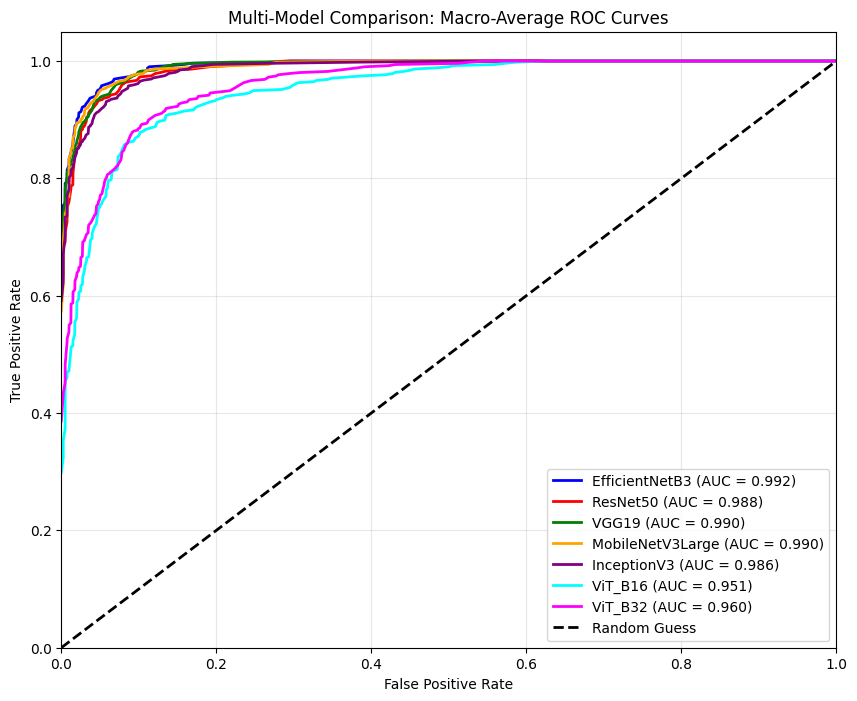

In [14]:
# --- 1. CRITICAL: Re-load Test Data with shuffle=False ---
# If test_ds is shuffled, your predictions will not match the true labels,
# and your ROC curves will look like random guesses.
print("Re-loading test dataset to ensure strictly no shuffling...")
test_ds_clean = tf.keras.utils.image_dataset_from_directory(
    os.path.join(split_output_dir, 'test'), # Ensure split_output_dir is defined
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical',
    shuffle=False # <--- EXTREMELY IMPORTANT
)

# --- 2. The Function Definition ---
def plot_model_comparison_roc(models_list, test_dataset, num_classes=4):
    plt.figure(figsize=(10, 8))
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'cyan', 'magenta', 'black'])
    
    # Prepare Test Labels (y_true)
    print("Pre-fetching Test Labels...")
    # Concatenate labels from the dataset
    y_true = np.concatenate([y for x, y in test_dataset], axis=0)
    
    models_found = False

    for model_name, color in zip(models_list, colors):
        weights_path = f"{model_name}_best.weights.h5"
        full_model_path = f"{model_name}_best.keras"
        
        path_to_load = None
        is_weights_only = False
        
        # Check which file exists
        if os.path.exists(weights_path):
            path_to_load = weights_path
            is_weights_only = True
        elif os.path.exists(full_model_path):
            path_to_load = full_model_path
            is_weights_only = False
        
        if not path_to_load:
            print(f"⚠️ Skipping {model_name} (Weights file not found)")
            continue
            
        models_found = True
        print(f"📈 Generating ROC for: {model_name}...")
        
        try:
            tf.keras.backend.clear_session()
            
            # Build the model architecture
            model, _ = build_expert_model(model_name)
            
            if model is None:
                print(f"❌ Could not build {model_name}")
                continue

            # Load weights
            model.load_weights(path_to_load)
            
            # Predict
            y_pred = model.predict(test_dataset, verbose=0)
            
            # Compute ROC metrics
            fpr = dict()
            tpr = dict()
            
            # Calculate metrics for each class
            for i in range(num_classes):
                fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])

            # Compute Macro-Average ROC
            all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
            mean_tpr = np.zeros_like(all_fpr)
            
            for i in range(num_classes):
                mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
            
            mean_tpr /= num_classes
            macro_auc = auc(all_fpr, mean_tpr)
            
            plt.plot(
                all_fpr, 
                mean_tpr, 
                label=f'{model_name} (AUC = {macro_auc:.3f})',
                color=color, 
                linewidth=2
            )
            
        except Exception as e:
            print(f"❌ Error processing {model_name}: {e}")

    if not models_found:
        print("\n❌ NO MODELS FOUND. Did training finish successfully?")
        return

    # Finalize Plot
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-Model Comparison: Macro-Average ROC Curves')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

# --- 3. EXECUTION (The part needed to make it run) ---
# Ensure MODELS_TO_TRAIN is defined
if 'MODELS_TO_TRAIN' not in locals():
    # Fallback list if variable is lost
    MODELS_TO_TRAIN = ['EfficientNetB3', 'ResNet50', 'VGG19', 'ViT_B16', 'ViT_B32']

plot_model_comparison_roc(MODELS_TO_TRAIN, test_ds_clean)

In [15]:
# 1. SETUP PATHS
MODELS_TO_TEST = [
    'EfficientNetB3',
    'ResNet50',
    'VGG19',
    'MobileNetV3Large',
    'InceptionV3',
    'ViT_B16'
]

models_dir = '/kaggle/input/outputmodel'       
test_dir = '/kaggle/working/dise_split/test/'  

class_names = ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

print(f"Models Directory: {models_dir}")
print(f"Test Directory: {test_dir}")

# 2. PREPARE DATA GENERATOR (NO RESCALE)
test_datagen = ImageDataGenerator()  # Raw inputs

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE, # Image size (224,224)
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    classes=class_names
)

# 3. RUN EVALUATION
print("\nRUNNING EVALUATION...\n")

final_results = {}

for model_name in MODELS_TO_TEST:
    print(f"Testing: {model_name}")
    tf.keras.backend.clear_session()
    
    try:
        # A. Build the architecture using the CLEAN name
        # e.g., build_expert_model('EfficientNetB3')
        model, _ = build_expert_model(model_name) 
        
        # B. Construct the correct filename
        if model_name == 'ViT_B16':
            filename = f"{model_name}_best.weights.h5"
        else:
            filename = f"{model_name}_best.keras"
            
        # C. Create the FULL PATH to the uploaded dataset
        weights_path = os.path.join(models_dir, filename)
        
        # D. Check and Load
        if os.path.exists(weights_path):
            print(f"Loading: {filename}")
            
            # ViT loads weights into the build; others load the full model file
            if model_name == 'ViT_B16':
                model.load_weights(weights_path)
            else:
                # We load weights into the fresh architecture to be safe
                model.load_weights(weights_path)
                
            model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
            
            # Evaluate
            loss, acc = model.evaluate(test_generator, verbose=1)
            final_results[model_name] = acc
            print(f" Accuracy: {acc*100:.2f}%")
        else:
            print(f" File NOT FOUND at: {weights_path}")
            
    except Exception as e:
        print(f"Error: {e}")

# 4. FINAL LEADERBOARD
print("\nFINAL TEST LEADERBOARD")
if final_results:
    df = pd.DataFrame.from_dict(final_results, orient='index', columns=['Test Accuracy'])
    print(df.sort_values(by='Test Accuracy', ascending=False))

Models Directory: /kaggle/input/outputmodel
Test Directory: /kaggle/working/dise_split/test/
Found 531 images belonging to 4 classes.

RUNNING EVALUATION...

Testing: EfficientNetB3
Loading: EfficientNetB3_best.keras


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 453ms/step - accuracy: 0.9485 - loss: 0.1458
 Accuracy: 92.28%
Testing: ResNet50
Loading: ResNet50_best.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 292ms/step - accuracy: 0.9334 - loss: 0.2661
 Accuracy: 88.32%
Testing: VGG19
Loading: VGG19_best.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 252ms/step - accuracy: 0.9445 - loss: 0.1711
 Accuracy: 91.53%
Testing: MobileNetV3Large


/usr/local/lib/python3.11/dist-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


Loading: MobileNetV3Large_best.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 350ms/step - accuracy: 0.9509 - loss: 0.1667
 Accuracy: 91.53%
Testing: InceptionV3
Loading: InceptionV3_best.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 378ms/step - accuracy: 0.9298 - loss: 0.2536
 Accuracy: 91.15%
Testing: ViT_B16


/usr/local/lib/python3.11/dist-packages/vit_keras/utils.py:85: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Loading: ViT_B16_best.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 364ms/step - accuracy: 0.8776 - loss: 0.3064
 Accuracy: 86.25%

FINAL TEST LEADERBOARD
                  Test Accuracy
EfficientNetB3         0.922787
VGG19                  0.915254
MobileNetV3Large       0.915254
InceptionV3            0.911488
ResNet50               0.883239
ViT_B16                0.862524


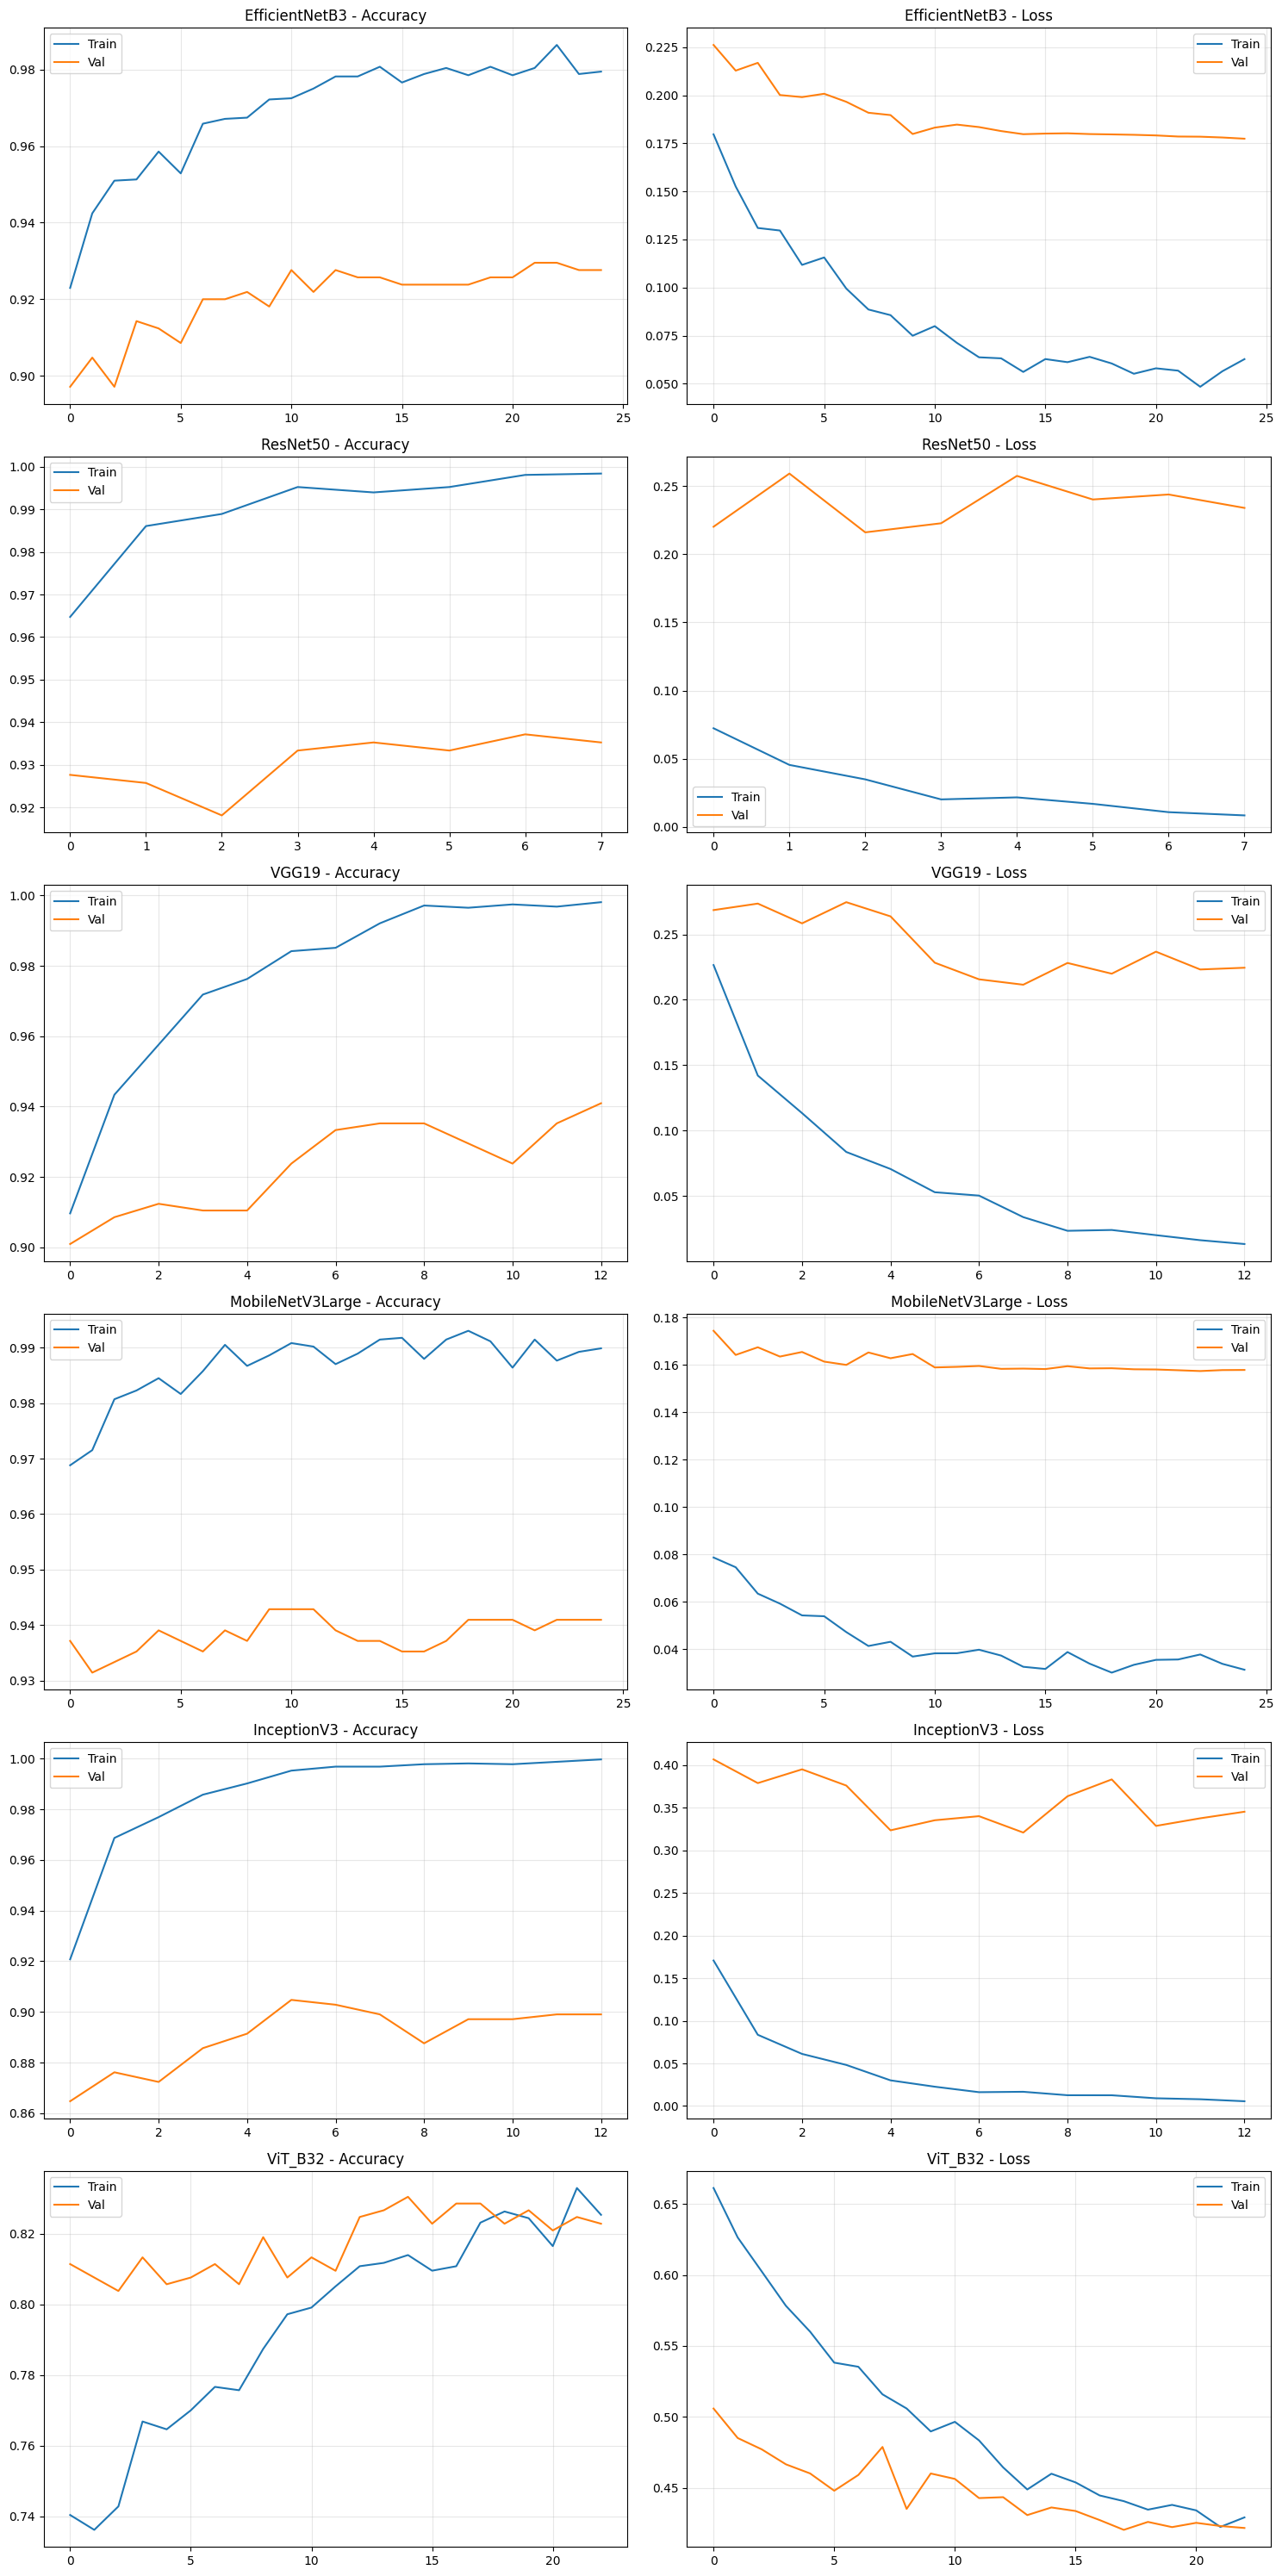

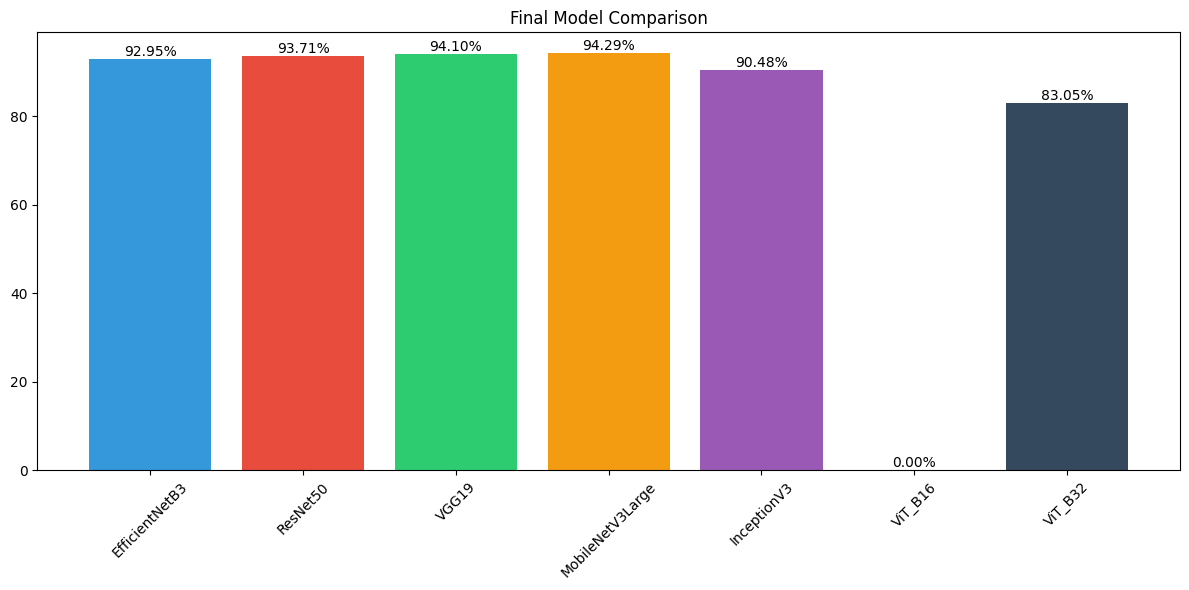

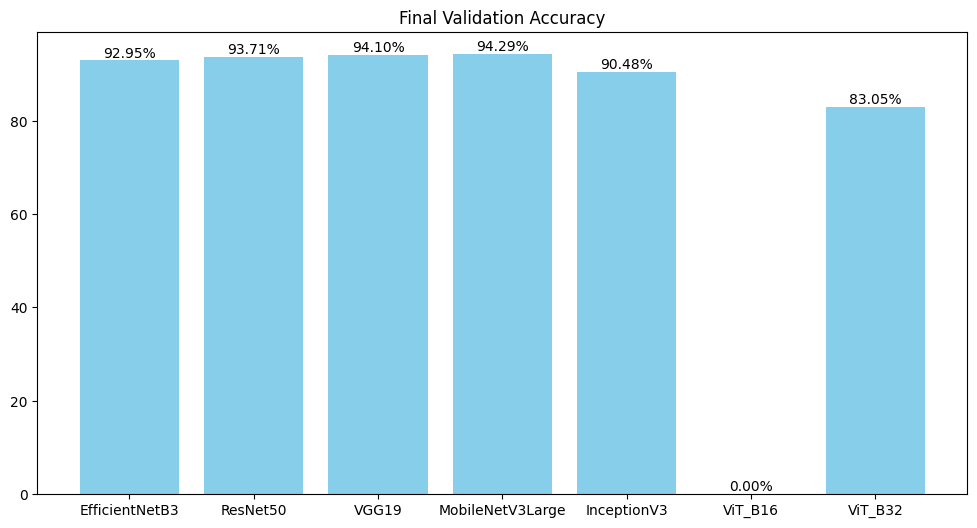

In [16]:
# --- (New) 3. Define the missing variable based on your loop data ---
trained_models = list(histories.keys())

if trained_models:
    # A. Training Curves
    fig, axes = plt.subplots(len(trained_models), 2, figsize=(15, 5*len(trained_models)))
    if len(trained_models) == 1: axes = [axes]

    for idx, model_name in enumerate(trained_models):
        h = histories[model_name]
        ax1, ax2 = axes[idx]
        
        ax1.plot(h['accuracy'], label='Train')
        ax1.plot(h['val_accuracy'], label='Val')
        ax1.set_title(f'{model_name} - Accuracy'); ax1.legend(); ax1.grid(True, alpha=0.3)
        
        ax2.plot(h['loss'], label='Train')
        ax2.plot(h['val_loss'], label='Val')
        ax2.set_title(f'{model_name} - Loss'); ax2.legend(); ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('final_curves.png')
    plt.show()

    # B. Leaderboard
    fig, ax = plt.subplots(figsize=(12, 6))
    names = list(all_results.keys())
    scores = [all_results[n] * 100 for n in names]
    
    bars = ax.bar(names, scores, color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6', '#8e44ad', '#34495e', '#16a085'])
    ax.bar_label(bars, fmt='%.2f%%')
    ax.set_title('Final Model Comparison')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('final_leaderboard.png')
    plt.show()

    # 2. Plot Leaderboard (Using 'all_results')
    fig, ax = plt.subplots(figsize=(12, 6))
    
    names = list(all_results.keys())
    scores = [all_results[n] * 100 for n in names] # Convert 0.85 -> 85.0
    
    bars = ax.bar(names, scores, color='skyblue')
    ax.bar_label(bars, fmt='%.2f%%')
    ax.set_title('Final Validation Accuracy')
    
    plt.show()

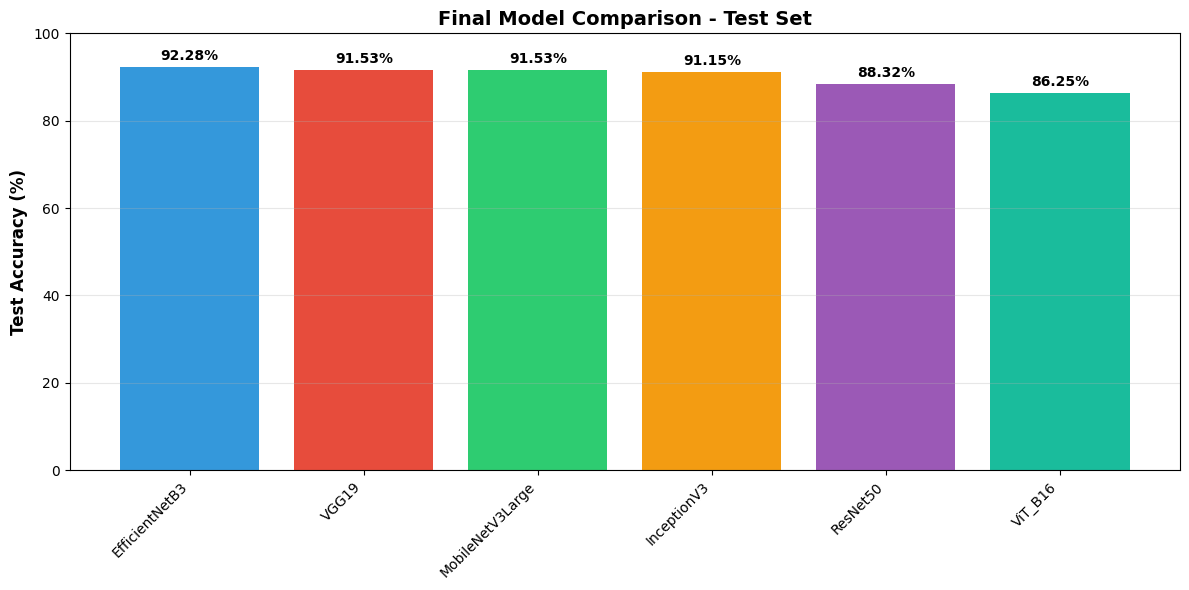

In [17]:
# Data from evualtion loop
if final_results:
    # Convert to DataFrame for easier plotting
    df = pd.DataFrame.from_dict(final_results, orient='index', columns=['Test Accuracy'])
    df['Test Accuracy'] = df['Test Accuracy'] * 100  # Convert to percentage
    df = df.sort_values(by='Test Accuracy', ascending=False)
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Create bars with different colors
    colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c']
    bars = ax.bar(df.index, df['Test Accuracy'], color=colors[:len(df)])
    
    # Styling
    ax.set_ylabel('Test Accuracy (%)', fontsize=12, fontweight='bold')
    ax.set_title('Final Model Comparison - Test Set', fontsize=14, fontweight='bold')
    ax.set_ylim([0, 100])
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add numbers on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.2f}%',
                ha='center', va='bottom', fontweight='bold')
    
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('final_model_comparison.png', dpi=300)
    plt.show()
else:
    print("No results found. Did you run the evaluation loop above?")

🚀 Generating Confusion Matrices for 7 Models...


👉 PROCESSING: EfficientNetB3
   Loading weights from: EfficientNetB3_best.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 694ms/step


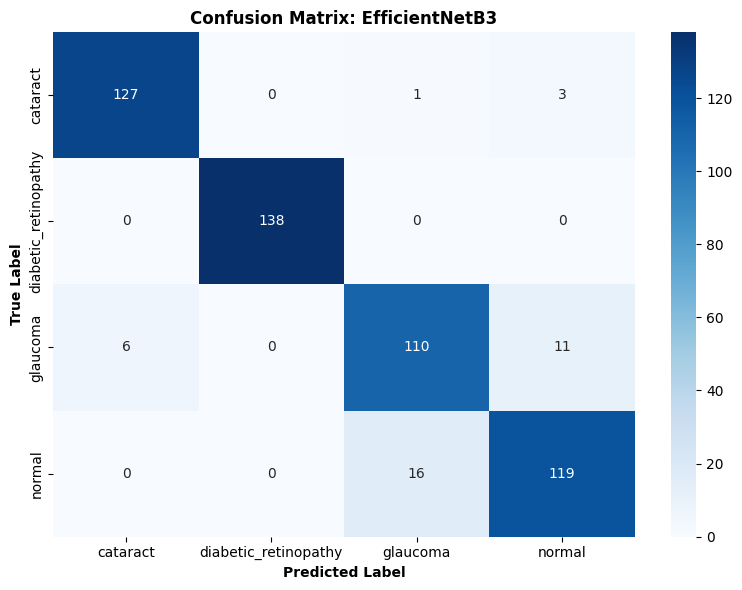


📊 Classification Report for EfficientNetB3:
                      precision    recall  f1-score   support

            cataract       0.95      0.97      0.96       131
diabetic_retinopathy       1.00      1.00      1.00       138
            glaucoma       0.87      0.87      0.87       127
              normal       0.89      0.88      0.89       135

            accuracy                           0.93       531
           macro avg       0.93      0.93      0.93       531
        weighted avg       0.93      0.93      0.93       531


👉 PROCESSING: ResNet50
   Loading weights from: ResNet50_best.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 407ms/step


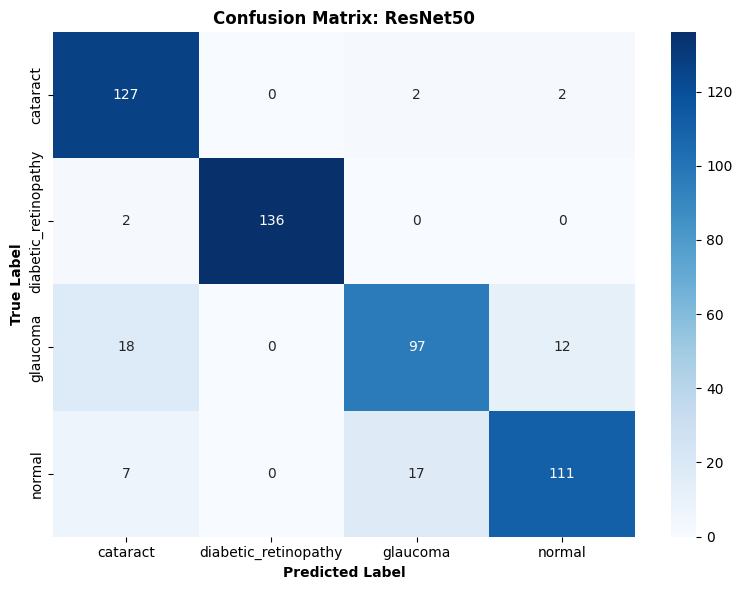


📊 Classification Report for ResNet50:
                      precision    recall  f1-score   support

            cataract       0.82      0.97      0.89       131
diabetic_retinopathy       1.00      0.99      0.99       138
            glaucoma       0.84      0.76      0.80       127
              normal       0.89      0.82      0.85       135

            accuracy                           0.89       531
           macro avg       0.89      0.89      0.88       531
        weighted avg       0.89      0.89      0.89       531


👉 PROCESSING: VGG19
   Loading weights from: VGG19_best.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 248ms/step


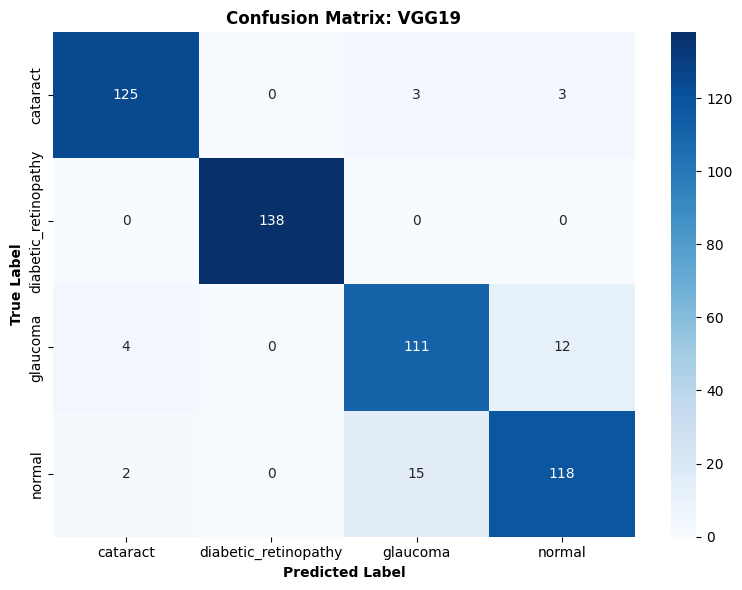


📊 Classification Report for VGG19:
                      precision    recall  f1-score   support

            cataract       0.95      0.95      0.95       131
diabetic_retinopathy       1.00      1.00      1.00       138
            glaucoma       0.86      0.87      0.87       127
              normal       0.89      0.87      0.88       135

            accuracy                           0.93       531
           macro avg       0.93      0.93      0.93       531
        weighted avg       0.93      0.93      0.93       531


👉 PROCESSING: MobileNetV3Large
   Loading weights from: MobileNetV3Large_best.keras


/usr/local/lib/python3.11/dist-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 437ms/step


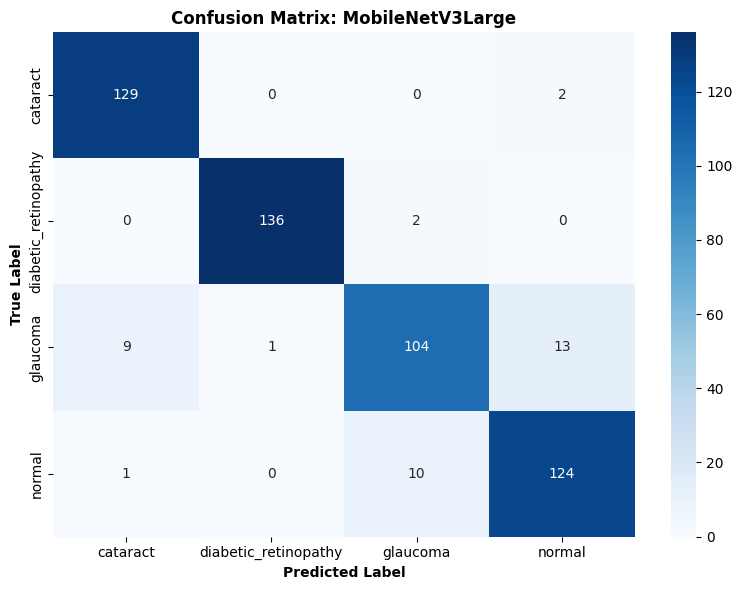


📊 Classification Report for MobileNetV3Large:
                      precision    recall  f1-score   support

            cataract       0.93      0.98      0.96       131
diabetic_retinopathy       0.99      0.99      0.99       138
            glaucoma       0.90      0.82      0.86       127
              normal       0.89      0.92      0.91       135

            accuracy                           0.93       531
           macro avg       0.93      0.93      0.93       531
        weighted avg       0.93      0.93      0.93       531


👉 PROCESSING: InceptionV3
   Loading weights from: InceptionV3_best.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 498ms/step


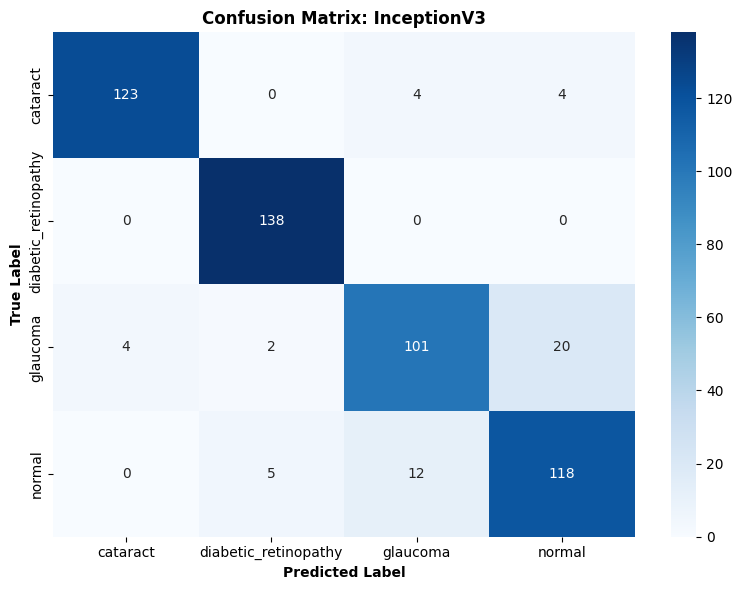


📊 Classification Report for InceptionV3:
                      precision    recall  f1-score   support

            cataract       0.97      0.94      0.95       131
diabetic_retinopathy       0.95      1.00      0.98       138
            glaucoma       0.86      0.80      0.83       127
              normal       0.83      0.87      0.85       135

            accuracy                           0.90       531
           macro avg       0.90      0.90      0.90       531
        weighted avg       0.90      0.90      0.90       531


👉 PROCESSING: ViT_B16
   Loading weights from: ViT_B16_best.weights.h5


/usr/local/lib/python3.11/dist-packages/vit_keras/utils.py:85: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 448ms/step


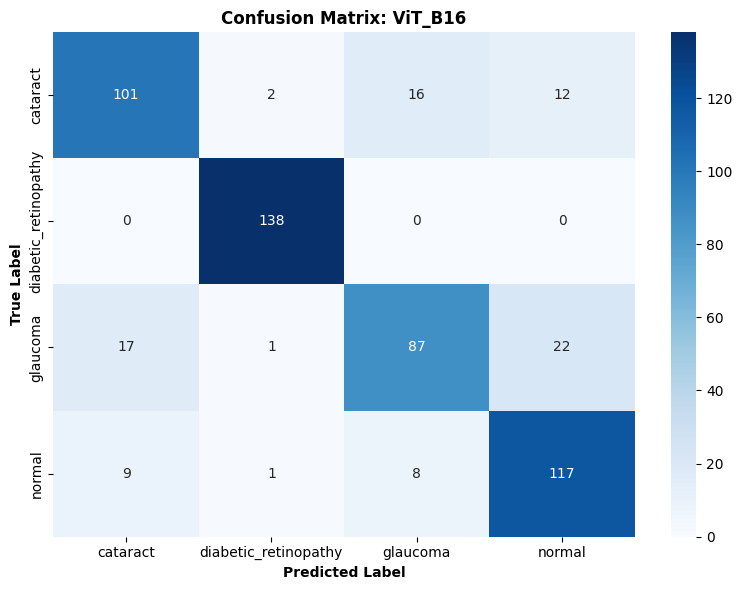


📊 Classification Report for ViT_B16:
                      precision    recall  f1-score   support

            cataract       0.80      0.77      0.78       131
diabetic_retinopathy       0.97      1.00      0.99       138
            glaucoma       0.78      0.69      0.73       127
              normal       0.77      0.87      0.82       135

            accuracy                           0.83       531
           macro avg       0.83      0.83      0.83       531
        weighted avg       0.83      0.83      0.83       531


👉 PROCESSING: ViT_B32
   Loading weights from: ViT_B32_best.weights.h5


/usr/local/lib/python3.11/dist-packages/vit_keras/utils.py:85: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 387ms/step


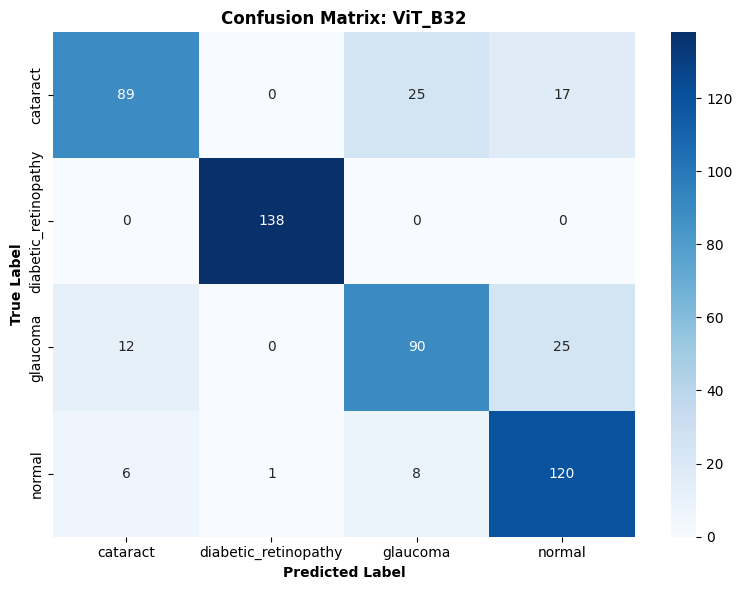


📊 Classification Report for ViT_B32:
                      precision    recall  f1-score   support

            cataract       0.83      0.68      0.75       131
diabetic_retinopathy       0.99      1.00      1.00       138
            glaucoma       0.73      0.71      0.72       127
              normal       0.74      0.89      0.81       135

            accuracy                           0.82       531
           macro avg       0.82      0.82      0.82       531
        weighted avg       0.83      0.82      0.82       531



In [20]:
# --- CONFIGURATION ---
# Ensure this list matches what you actually trained
MODELS_TO_PROCESS = MODELS_TO_TRAIN 

# Re-create the test generator to ensure it is absolutely not shuffled
# If you are using 'test_ds' (tf.data.Dataset) from previous steps, use that instead.
# If using ImageDataGenerator, use this:
test_generator.reset() # Important to reset pointer
test_generator.shuffle = False # Critical for confusion matrix alignment

print(f"🚀 Generating Confusion Matrices for {len(MODELS_TO_PROCESS)} Models...\n")

for model_name in MODELS_TO_PROCESS:
    print(f"\n{'='*60}")
    print(f"👉 PROCESSING: {model_name}")
    print(f"{'='*60}")
    
    try:
        tf.keras.backend.clear_session()
        
        # 1. Determine File Path
        # Check for both file types to be safe
        weights_path_h5 = f"{model_name}_best.weights.h5"
        weights_path_keras = f"{model_name}_best.keras"
        
        path_to_load = None
        is_weights_only = False
        
        if os.path.exists(weights_path_h5):
            path_to_load = weights_path_h5
            is_weights_only = True # Usually true for .weights.h5
        elif os.path.exists(weights_path_keras):
            path_to_load = weights_path_keras
            is_weights_only = False # Usually full model for .keras
            
        if not path_to_load:
            print(f"⚠️ Skipping {model_name}: Weights file not found.")
            continue

        # 2. Build & Load
        print(f"   Loading weights from: {path_to_load}")
        
        # Build the architecture first
        model, _ = build_expert_model(model_name)
        
        if model is None:
            print(f"❌ Failed to build architecture for {model_name}")
            continue
            
        # Load the weights into the architecture
        # Note: Even for .keras files, if we built the model manually above, 
        # load_weights is often safer than load_model to avoid custom object issues
        model.load_weights(path_to_load)
        
        # 3. Predict
        # If using tf.data.Dataset (test_ds), use this:
        # predictions = model.predict(test_ds, verbose=1)
        # y_true = np.concatenate([y for x, y in test_ds], axis=0) 
        # true_classes = np.argmax(y_true, axis=1)
        
        # If using ImageDataGenerator (test_generator), use this:
        test_generator.reset() # Reset generator for every model
        predictions = model.predict(test_generator, verbose=1)
        predicted_classes = np.argmax(predictions, axis=1)
        true_classes = test_generator.classes
        class_labels = list(test_generator.class_indices.keys())

        # 4. Plot Confusion Matrix
        cm = confusion_matrix(true_classes, predicted_classes)
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=class_labels, yticklabels=class_labels)
        plt.ylabel('True Label', fontweight='bold')
        plt.xlabel('Predicted Label', fontweight='bold')
        plt.title(f'Confusion Matrix: {model_name}', fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        # 5. Print Classification Report
        print(f"\n📊 Classification Report for {model_name}:")
        print(classification_report(true_classes, predicted_classes, target_names=class_labels))
        
    except Exception as e:
        print(f"❌ Error processing {model_name}: {e}")